In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [2]:
# leggo il dataset ed il target

dataset = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned\dataset.csv', header = 0)
features_names = list(dataset.columns) # ottengo i nomi delle features
features_names.pop(0) # rimuovo il primo addresses, in quanto non e' una feature
pairs_number_features = list() # creo una lista che contiene coppie <#_feature, nome_feature>
idx = 0

while idx < len(features_names):
    pair = (idx, features_names[idx])
    pairs_number_features.append(pair)
    idx+=1
    
print(pairs_number_features)

target = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned\target.csv', header = 0)

[(0, 'balance'), (1, 'lifetime'), (2, 'tx_in'), (3, 'tx_out'), (4, 'investment_in'), (5, 'payment_out'), (6, 'investment_to_contract/tx_in'), (7, 'payment_from_contract/tx_out'), (8, '#addresses_paying_contract'), (9, '#addresses_paid_by_contract'), (10, 'mean_v1'), (11, 'sdev_v1'), (12, 'mean_v2'), (13, 'sdev_v2'), (14, 'paid_rate'), (15, 'paid_one'), (16, 'percentage_some_tx_in'), (17, 'sdev_tx_in'), (18, 'percentage_some_tx_out'), (19, 'sdev_tx_out'), (20, 'owner_gets_eth_Wo_investing'), (21, 'owner_gets_eth_investing'), (22, 'owner_no_eth')]


In [3]:
X = dataset.values[:, 1:] # rimuovo la prima colonna che contiene gli indirizzi
y = target.values

# divido in train set (TR) e test set (TS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y) 

In [4]:
flat_list_train = [item for sublist in y_train.tolist() for item in sublist]
print('Number of smart contract in train set::', flat_list_train.count(0))
print('Number of smart Ponzi in train set::', flat_list_train.count(1))
flat_list_test = [item for sublist in y_test.tolist() for item in sublist]
print('Number of smart contract in test set::', flat_list_test.count(0))
print('Number of smart Ponzi in test set::', flat_list_test.count(1))

Number of smart contract in train set:: 3107
Number of smart Ponzi in train set:: 538
Number of smart contract in test set:: 777
Number of smart Ponzi in test set:: 135


In [5]:
fbeta = make_scorer(fbeta_score, beta = 1.5)

In [6]:
# in questo dizionario inserisco i parametri con cui testare il DT
param_dist_DT = {
    'criterion' : ['entropy', 'gini'],
    'max_depth' : [5, 6, 7, 8, None],
    'max_features' : [15, 18, 21],
    'min_samples_split' : [5, 10, 15], # il valore tipico sta fra 1 e 40
    'class_weight' : [{0:1, 1:4}, {0:1, 1:4.25}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
}

In [7]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid = param_dist_DT, scoring = fbeta, cv = 3, n_jobs = 8)
grid_dt.fit(X_train, y_train) # alleno su train
y_pred_train = grid_dt.predict(X_train) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_dt.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_dt.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'class_weight': {0: 1, 1: 4.25}, 'criterion': 'gini', 'max_depth': 7, 'max_features': 15, 'min_samples_split': 10}
best score::  0.5917896708808945
recall score on TR::  0.7304832713754646
precision score on TR::  0.5918674698795181


In [8]:
clf_dt = DecisionTreeClassifier(**grid_dt.best_params_)
clf_dt.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_dt.score(X_train, y_train))
print('accuracy score on TS:: ', clf_dt.score(X_test, y_test))

accuracy score on TR::  0.8373113854595337
accuracy score on TS::  0.8070175438596491


In [11]:
param_dist_RF = {
            'n_estimators':[180, 190, 200],
            'min_samples_split' : [30, 35],
            'max_depth' : [8, 9, 10],
            'criterion':['gini', 'entropy'],
            'class_weight' : [{0:1, 1:5.5}, {0:1, 1:6}],
            'bootstrap': [True, False]
}

In [12]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_dist_RF, scoring = fbeta, cv = 3, n_jobs = 8)
grid_rf.fit(X_train, y_train.ravel())
y_pred_train = grid_rf.predict(X_train)
print('best hyperparameters:: ', grid_rf.best_params_)
print('best score:: ', grid_rf.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'bootstrap': False, 'class_weight': {0: 1, 1: 6}, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 30, 'n_estimators': 190}
best score::  0.615114076730555
recall score on TR::  0.8921933085501859
precision score on TR::  0.5194805194805194


In [13]:
clf_rf = RandomForestClassifier(**grid_dt.best_params_)
clf_rf.fit(X_train, y_train.ravel())
print('accuracy score on TR:: ', clf_rf.score(X_train, y_train))
print('accuracy score on TS:: ', clf_rf.score(X_test, y_test))

accuracy score on TR::  0.9146776406035665
accuracy score on TS::  0.8673245614035088


In [15]:
param_dist_XGB = {
                'learning_rate' : [0.1],
                'n_estimators' : [80, 90, 100, 110, 120],
                'scale_pos_weight' : [5.5, 6],
                'max_depth' : [6,7],
                'gamma' : [0, 0.1, 0.2, 0.3],
                'reg_lambda' : [50]
}

In [16]:
# effettuo la GridSearchCV() per scegliere i migliori iperparametri
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder = False, eval_metric = 'aucpr'), 
                        param_grid = param_dist_XGB, scoring = fbeta, cv = 3, n_jobs = 8)
grid_xgb.fit(X_train, y_train)
y_pred_train = grid_xgb.predict(X_train)
print('best hyperparameters:: ', grid_xgb.best_params_)
print('best score:: ', grid_xgb.best_score_)
print('recall score on TR:: ', recall_score(y_train, y_pred_train))
print('precision score on TR:: ', precision_score(y_train, y_pred_train))

best hyperparameters::  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 110, 'reg_lambda': 50, 'scale_pos_weight': 6}
best score::  0.642026654155288
recall score on TR::  0.879182156133829
precision score on TR::  0.6340482573726541


In [17]:
clf_xgb = xgb.XGBClassifier(learning_rate = 0.1, n_estimators = 110, scale_pos_weight = 6, max_depth = 6, 
                            gamma=0.1, reg_lambda = 50, use_label_encoder = False, eval_metric='aucpr')
clf_xgb.fit(X_train, y_train)
print('accuracy score on TR:: ', clf_xgb.score(X_train, y_train))
print('accuracy score on TS:: ', clf_xgb.score(X_test, y_test))

accuracy score on TR::  0.9072702331961591
accuracy score on TS::  0.8530701754385965


In [19]:
model_params = {
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': { 
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [5, 6, 7, 8, None],
            'max_features' : [15, 18, 21],
            'min_samples_split' : [5, 10, 15], # il valore tipico sta fra 1 e 40
            'class_weight' : [{0:1, 1:4}, {0:1, 1:4.25}, {0:1, 1:4.5}] # pesi, il valore raccomandato e' sum(negative instances)/sum(positive instances)
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[180, 190, 200],
            'min_samples_split' : [30, 35],
            'max_depth' : [8, 9, 10],
            'criterion':['gini', 'entropy'],
            'class_weight' : [{0:1, 1:5.5}, {0:1, 1:6}],
            'bootstrap': [True, False]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier(learning_rate = 0.1, # funziona bene per valori fra 0.01 e 0.25
                                   colsample_bytree = 0.8,
                                   eval_metric = 'aucpr', 
                                   use_label_encoder = False),
        'params': {
                'learning_rate' : [0.1],
                'n_estimators' : [80, 90, 100, 110, 120],
                'scale_pos_weight' : [5.5, 6],
                'max_depth' : [6,7],
                'gamma' : [0, 0.1, 0.2, 0.3],
                'reg_lambda' : [50]
        }
    }
}

In [20]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], scoring = fbeta, cv=3, return_train_score=False, n_jobs=8)
    clf.fit(X_train, y_train.ravel())
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_ # necessario per riallenare
    })
    
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,decision_tree,0.589375,"{'class_weight': {0: 1, 1: 4.5}, 'criterion': 'gini', 'max_depth': 8, 'max_features': 15, 'min_samples_split': 15}"
1,random_forest,0.615627,"{'bootstrap': False, 'class_weight': {0: 1, 1: 6}, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 30, 'n_estimators': 200}"
2,xgboost,0.641344,"{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 90, 'reg_lambda': 50, 'scale_pos_weight': 6}"


In [21]:
models_list = sorted(scores, key=lambda d: d['best_score']) # ordino in base al best_score
model = models_list[-1] # prendo l'ultimo modello (quello con score piu' alto)
clf = model.get('best_estimator') # ottengo i valori con cui allenare
clf.fit(X_train, y_train) # rialleno

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='aucpr', gamma=0.2,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=90, n_jobs=12, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=50, scale_pos_weight=6,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

                    (Number, Feature)  Importance
0                      (15, paid_one)    0.302860
1                          (2, tx_in)    0.075543
2   (6, investment_to_contract/tx_in)    0.053709
3   (20, owner_gets_eth_Wo_investing)    0.051192
4                    (17, sdev_tx_in)    0.049757
5                       (10, mean_v1)    0.040622
6                       (1, lifetime)    0.038460
7   (7, payment_from_contract/tx_out)    0.036845
8         (16, percentage_some_tx_in)    0.034931
9                        (0, balance)    0.033519
10   (9, #addresses_paid_by_contract)    0.031931
11                      (13, sdev_v2)    0.029472
12                    (14, paid_rate)    0.027087
13    (8, #addresses_paying_contract)    0.026228
14     (21, owner_gets_eth_investing)    0.023663
15                        (3, tx_out)    0.023026
16       (18, percentage_some_tx_out)    0.020886
17                  (19, sdev_tx_out)    0.019214
18                      (11, sdev_v1)    0.018923


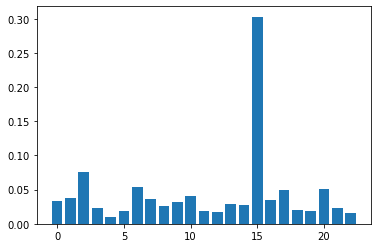

In [22]:
features_importances = clf.feature_importances_
res = dict(zip(pairs_number_features, features_importances))
sorted_dict = dict(sorted(res.items(), key=lambda item: item[1], reverse = True))
print(pd.DataFrame(list(sorted_dict.items()),columns=['(Number, Feature)', 'Importance']))
plt.bar(range(len(features_importances)), features_importances)
plt.show()

precision score::  0.5
recall score::  0.6962962962962963
accuracy score::  0.8519736842105263
fbeta score::  0.6456043956043956
F1 score:: 0.5820433436532508


<AxesSubplot:>

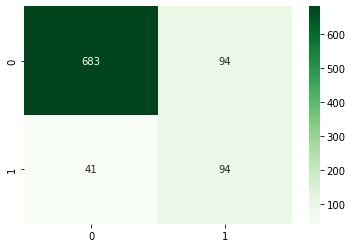

In [23]:
# faccio la predizione e stampo le statistiche sul modello migliore (quello che ha vinto nella GridSearch)

y_pred = clf.predict(X_test)
print('precision score:: ', precision_score(y_test, y_pred)) # TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred))	     # TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred))	 # (TP + TN)/ (TP + FN + TN + FP)
print('fbeta score:: ', fbeta_score(y_test, y_pred, beta = 2))
print('F1 score::', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')

precision score::  0.4409090909090909
recall score::  0.7185185185185186
accuracy score::  0.8234649122807017
F1 score:: 0.5464788732394366


<AxesSubplot:>

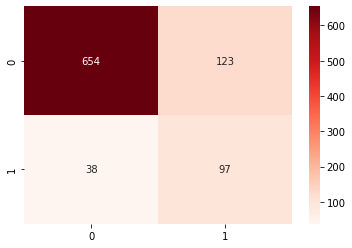

In [24]:
# risultati ottenuti con il secondo migliore

model = models_list[1] # prendo il modello medio
clf2 = model.get('best_estimator') # ottengo i valori con cui allenare
clf2.fit(X_train, y_train.ravel()) # rialleno
y_pred2 = clf2.predict(X_test)
print('precision score:: ', precision_score(y_test, y_pred2)) #  TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred2))	     # 	TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred2))	 #  (TP + TN)/ (TP + FN + TN + FP)
print('F1 score::', f1_score(y_test, y_pred2))
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')

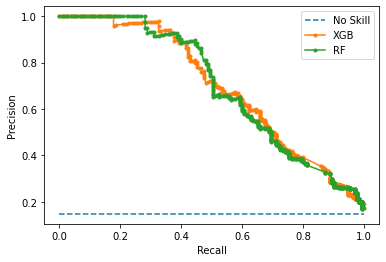

In [25]:
# predict probabilities
y_pred_proba_winner = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
y_pred_proba_w = y_pred_proba_winner[:, 1]
# calculate pr-curve
p, r, thrs = precision_recall_curve(y_test, y_pred_proba_w)


y_pred_proba_second = clf2.predict_proba(X_test)
y_pred_proba_s = y_pred_proba_second[:, 1]
p2, r2, thrs2 = precision_recall_curve(y_test, y_pred_proba_s)
# plot the roc curve for the model
no_skill = len(y_test[y_test == 1]) / len(y_test)
plt.plot([0,1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.plot(r, p, marker = '.', label = 'XGB')
plt.plot(r2, p2, marker = '.', label = 'RF')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [26]:
# convert to f score
beta = 1.75 # se metto valori <= 1 allora e' come favorire F1 o precision, piu' alzo beta e piu' importanza ha la recall
fbetaw = ((1 + beta**2) * p * r) / (beta**2 * p + r)
# locate the index of the largest f score
ixw = np.argmax(fbetaw)
fbetas = ((1 + beta**2) * p2 * r2) / (beta**2 * p2 + r2)
ixs = np.argmax(fbetas)
print('Best Threshold of the winner model = %f, Fbeta-Score = %.3f' % (thrs[ixw], fbetaw[ixw]))
print('Best Threshold of the second model = %f, Fbeta-Score = %.3f' % (thrs2[ixs], fbetas[ixs]))

Best Threshold of the winner model = 0.590766, Fbeta-Score = 0.642
Best Threshold of the second model = 0.558189, Fbeta-Score = 0.638


<AxesSubplot:>

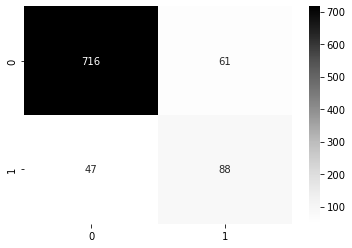

In [27]:
y_pred_thrs = np.where(clf.predict_proba(X_test)[:, 1] > thrs[ixw], 1, 0)
cm_thrs = confusion_matrix(y_test, y_pred_thrs)
sns.heatmap(cm_thrs, annot=True, cmap='Greys', fmt='d')

<AxesSubplot:>

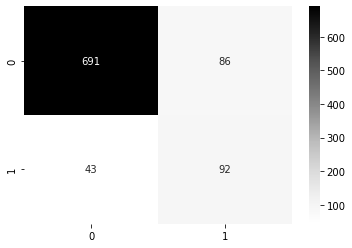

In [28]:
y_pred_thrs = np.where(clf2.predict_proba(X_test)[:, 1] > thrs2[ixs], 1, 0)
cm_thrs = confusion_matrix(y_test, y_pred_thrs)
sns.heatmap(cm_thrs, annot=True, cmap='Greys', fmt='d')